# DECISION TREE FOR FOOD 101

### This code combines LBP features with EfficientNet deep features and feeds them into a Decision Tree.

### *   FEATURE EXTRACTION: LBP (Local Binary Patterns) and EfficientNet
### This method extracts texture features in the image unlike the color histogram that extracts color features and the Histogram of Gradients (HOG).
# LBNP takes a center pixel and compares its value to each surrounding pixel in a neighborhood

# Food Image Classification for Nutritional Estimation TEST 6 using SCIKIT_LEARN

# IMPORTING LIBRARIES

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.pipeline import Pipeline
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import FunctionTransformer
from skimage.transform import rotate
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# LOAD FOOD101 TENSORFLOW DATASET & PRINT FIRST 10 FOOD CLASSES

In [ ]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

class_names = info.features["label"].names[:10]
# Get the first 10 class names

# Print information about the dataset
print("First 10 classes:", class_names)
# Print class names of the first 10 classes for confirmation


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4YNDR9_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4YNDR9_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
First 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


# FILTER FOOD101  MATCHING THE FIRST 10 CLASS NAMES SELECTED

In [20]:
# Function to filter dataset to only the first 10 classes

def filter_classes(image, label):
  # paremter image and label for labeling each food image class

    return label < 10
    # Keep only images where label is between 0 and 9 (first 10 classes)

# Apply filter to remove unwanted classes in FOOD 101 dataset
filtered_dataset = dataset.filter(filter_classes)

# Count dataset size to ensure same size across. SUM of all 1s
dataset_size = sum(1 for _ in filtered_dataset)

# print total images in filtered dataset
print(f"Total images in first 10 classes: {dataset_size}")

Total images in first 10 classes: 7500


# DISPLAY ONE  IMAGE PER UNIQUE FOOD CLASS

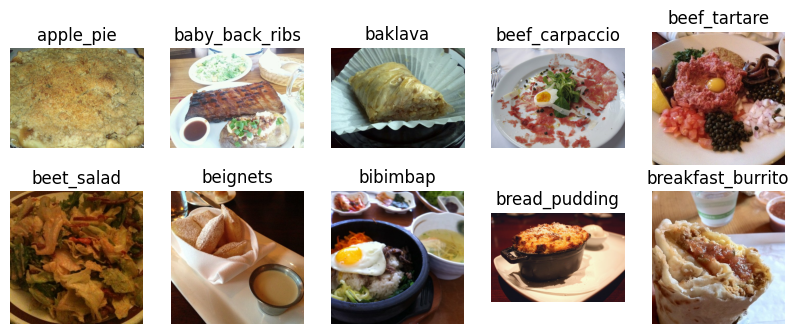

In [21]:
# Dictionary to store one image per class
class_images = {}

# for loop to iterate through filtered 10 classes dataset
for image, label in filtered_dataset:
  # for each image and class label

    label_value = label.numpy()
    # for converting the tensorflow tensor label to python numpy integer
    # integer is need for the indexing in teh dictionary

    # interating through the dictionary storing the first images for each unique food classs label
    if label_value not in class_images:
    # if the integer as the label is not in the dictionary

        class_images[label_value] = image
        # aasign an image from the dataset corresponding uniquely to the dictionary stored food class labels

    if len(class_images) == 10:
    # Stop when we have one image per class coreresponding to each food class
        break

# Plot images
plt.figure(figsize=(10, 10))
# creating a new figure with 10 inches width and height

# iteraing over each key- value pair (class label and an image)
for i, (label, image) in enumerate(sorted(class_images.items())):
    # sorting the items in order and enumerating

    plt.subplot(5, 5, i + 1)
    # subplot in figure for 5 rows and 5 columns

    plt.imshow(image.numpy())
    # displays the image subplot
    # converting the tensorflow tensor image to python numpy integer for matplotlib

    plt.title(class_names[label])
    # sets the title of each plot to the label of each class name

    plt.axis("off")
    # removes axis ticks

plt.show()
# displays complete figure

# DATASET PREPARATION: Split into Train & Validation Sets

In [22]:
# Define train-validation split (80-20)
train_split = 0.8
# 80% for training

train_size = int(train_split * dataset_size)
# the defined split 0.8 multiplied by the dataset size, ensured to return integer and stored in train_size variable

# Split the dataset
# train set
train_ds = filtered_dataset.take(train_size)
# take () method extracts the train_size from the filtered dataset, 80% of filtered dataset

# validation set
val_ds = filtered_dataset.skip(train_size)
# skip () method ignores the train_size from the filtered dataset, remaining 20% of filtered dataset used for validation
# remaining 20% sample from dataset

print(f"Training set size: {train_size}")
print(f"Validation set size: {dataset_size - train_size}")

Training set size: 6000
Validation set size: 1500


# DATASET PREPROCESSING: Resizing image and normalisation

In [23]:
def preprocess(image, label):
    # Ensure the image has 3 dimensions (height, width, channels)
    if len(image.shape) == 2:  # Grayscale image (height, width)
        image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    elif len(image.shape) == 3 and image.shape[-1] == 1:  # Single-channel grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert to 3 channels

    # Ensure the image has 3 channels
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)

    # Resize to 64x64 and normalize pixel values
    image = tf.image.resize(image, (224, 224)) / 255.0

    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

# Checking Image Shapes

In [24]:
# Check the shape of images
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First image shape:", images[0].shape)
    print("Image data type:", images.dtype)
    print("First few pixel values:", images[0,0,0:5])

Image batch shape: (32, 224, 224, 3)
First image shape: (224, 224, 3)
Image data type: <dtype: 'float32'>
First few pixel values: tf.Tensor(
[[0.3342337  0.10678271 0.09109644]
 [0.3484594  0.11708684 0.09355742]
 [0.359944   0.12857142 0.10504201]
 [0.347479   0.12787116 0.10434174]
 [0.2994598  0.10954382 0.09133655]], shape=(5, 3), dtype=float32)


# LBP for Texture features and EfficientNetB0 for Deep features Extraction

In [8]:
# === Extract LBP Features === #
def extract_lbp_features(image, P=20, R=4):
    image = image.numpy()
    gray = np.dot(image, [0.2989, 0.5870, 0.1140])  # Convert to grayscale
    gray = (gray * 255).astype(np.uint8)  # Convert to uint8 for LBP
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), density=True)
    return hist

# === Extract EfficientNet Features === #
base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

X_train, y_train = [], []
X_val, y_val = [], []

# Extract LBP & EfficientNet Features for Training Set
for images, labels in train_ds:
    efficientnet_features = base_model.predict(images)  # Extract EfficientNet features
    for i in range(len(images)):
        combined_features = np.hstack([extract_lbp_features(images[i]), efficientnet_features[i]])
        X_train.append(combined_features)
        y_train.append(labels[i].numpy())

# Extract LBP & EfficientNet Features for Validation Set
for images, labels in val_ds:
    efficientnet_features = base_model.predict(images)  # Extract EfficientNet features
    for i in range(len(images)):
        combined_features = np.hstack([extract_lbp_features(images[i]), efficientnet_features[i]])
        X_val.append(combined_features)
        y_val.append(labels[i].numpy())

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


# Fit on training data and transform both training and validation sets
scaler = StandardScaler()  # Initialize the scaler
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Print dataset shapes
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━

# NEXT METHOD:
# Trying alternative texture features like Local Binary Patterns (LBP) or Gabor filters.




# PCA for feature vector dimensionality reduction
# Why?
## The combined features extracted might come with noise from both features, PCA can help reduce that.

### TESTING DECISION TREE WITH AND WITHOUT PCA
### PCA COMPONENT 50 = LESS VALIDATION ACCURACY (0.21) THAN HISTOGRAM OF COLORS FEATURE EXTRACTION

# >>>>>>>>>>>>>>>>>>>>>>>>>
### PCA COMPONENT = 20
###RESULTED TO THE HIGHEST VALIDATION ACCURACY SO FAR 0.23666%
# >>>>>>>>>>>>>>>>>>>>>>>>>
### PCA COMPONENT = 30;
### POOR RESULTS LESS < 23%
# >>>>>>>>>>>>>>>>>>>>>>>>>
### PCA COMPONENT = 15;
### HAS THE BEST RESULTS WITH Validation Accuracy: 0.239

# Principal Component Analysis (PCA) for Dimensionality Reduction

In [9]:
apply_pca = True  # Set to False if you want to use raw features

if apply_pca:
    pca = PCA(n_components=15)  # You can tune the number of components
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    print("Feature vector size after PCA:", X_train.shape[1])

Feature vector size after PCA: 15


# Decision Tree HyperParameter Tuning (GRIDSEARCH)

In [10]:
# We'll use GridSearchCV to try different hyperparameters for the Decision Tree
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
}

# Training the Decision Tree

In [11]:
# Measure training time for runtime performance
start_time = time.time()

# --- K-Fold Cross-Validation --- #
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create and train decision tree
dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Calculate training time
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

print("Best parameters found:", grid_search.best_params_)
best_dt = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Training time: 64.96 seconds
Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}


In [25]:
# Evaluate on training data
y_train_pred = best_dt.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on validation data
y_val_pred = best_dt.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train Accuracy: 0.244
Validation Accuracy: 0.202


# Evaluation, Predictions and Peformance Calculation.


In [26]:
# Calculate loss (for example, using log_loss)
y_train_prob = best_dt.predict_proba(X_train)
y_val_prob = best_dt.predict_proba(X_val)
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)
print(f"Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")


# Get classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))


# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

Train loss: 2.0599, Validation loss: 2.5006

Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.15      0.09      0.11       152
   baby_back_ribs       0.17      0.33      0.22       135
          baklava       0.25      0.23      0.24       138
   beef_carpaccio       0.17      0.10      0.12       155
     beef_tartare       0.22      0.08      0.11       157
       beet_salad       0.24      0.17      0.20       144
         beignets       0.34      0.25      0.28       170
         bibimbap       0.26      0.34      0.30       166
    bread_pudding       0.16      0.14      0.15       144
breakfast_burrito       0.14      0.29      0.19       139

         accuracy                           0.20      1500
        macro avg       0.21      0.20      0.19      1500
     weighted avg       0.21      0.20      0.19      1500



# Visualize metrics: Accuracy and loss

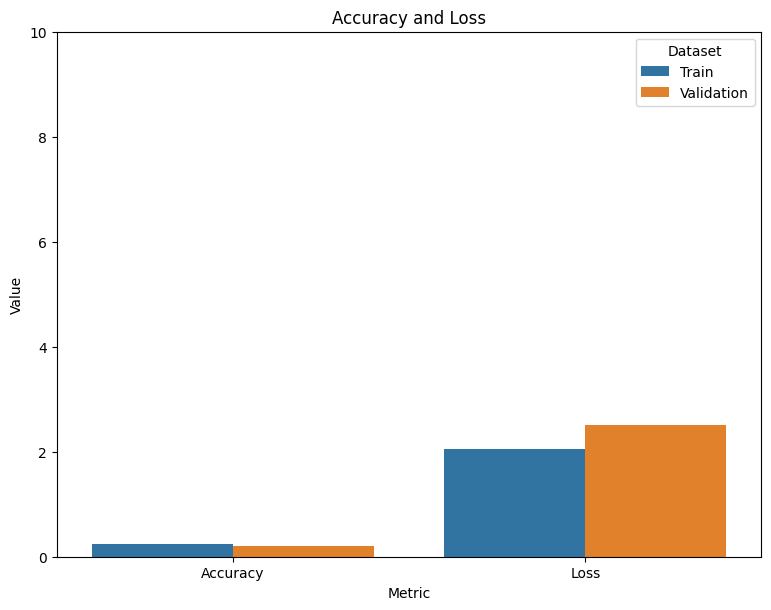

In [27]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Train': [train_accuracy, train_loss],
    'Validation': [val_accuracy, val_loss]
})
metrics_melted = pd.melt(metrics, id_vars=['Metric'], var_name='Dataset', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Dataset', data=metrics_melted)
plt.title('Accuracy and Loss')

plt.ylim(0,10)
plt.show()

# Visualize metrics: Confusion matrix

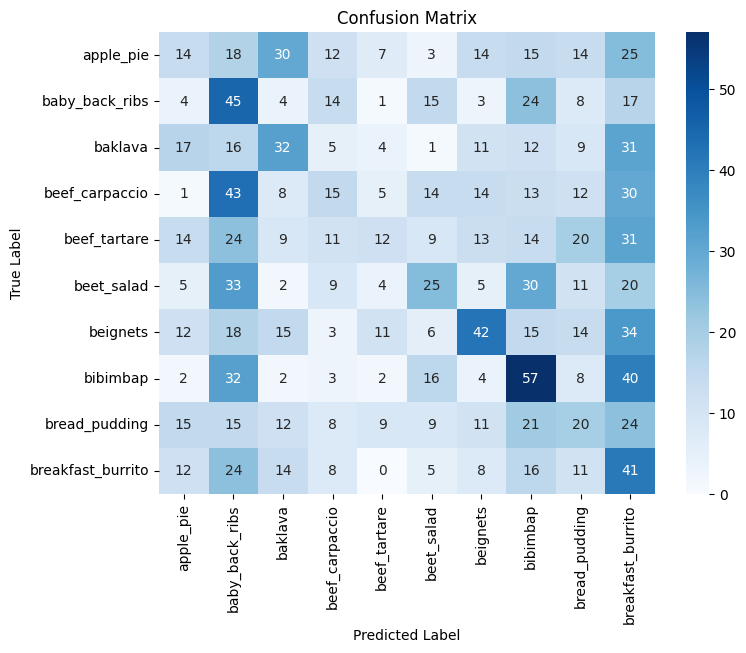

In [28]:
# 2. Plot confusion matrix
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize metrics: Precision, Recall, f1-score

<Figure size 1000x600 with 0 Axes>

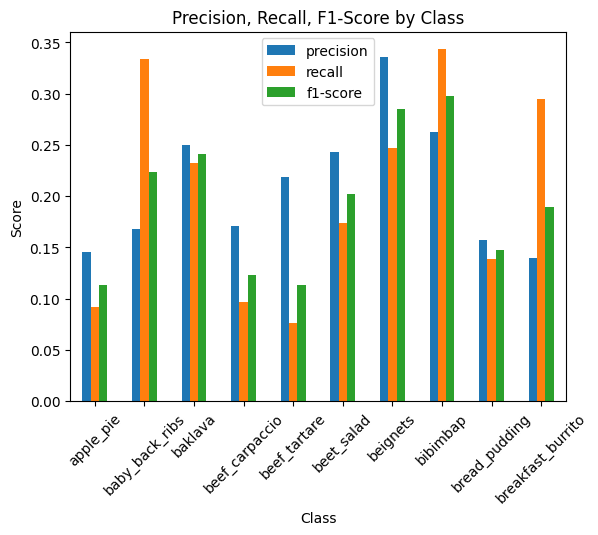

In [29]:
# 3. Plot precision, recall, f1-score
# Convert classification report to DataFrame for visualization
report_dict = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.iloc[:-3]  # Remove support and avg rows if present

plt.figure(figsize=(10, 6))
metrics_df = report_df[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar')
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Visualize metrics: Plot runtime performance

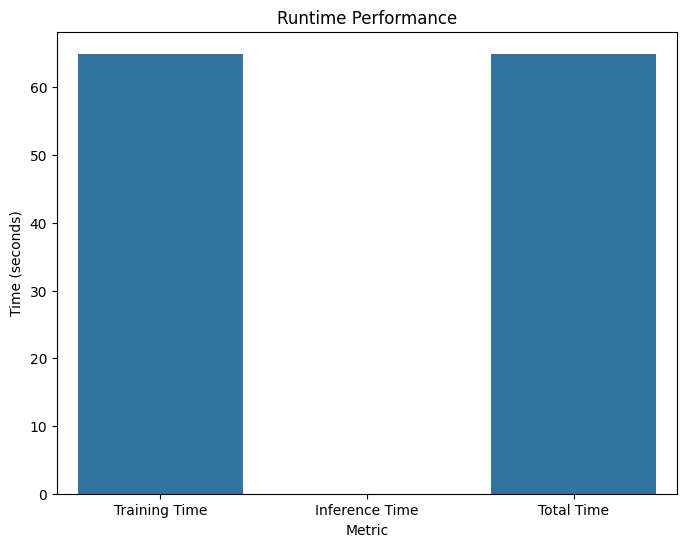

In [30]:
# 4. Plot runtime performance
# Here we show the runtime performance for training and inference
# Note: For demonstration, we use the grid search training time and a quick inference time measurement

inference_start = time.time()
_ = best_dt.predict(X_val)
inference_time = time.time() - inference_start

performance = pd.DataFrame({
    'Metric': ['Training Time', 'Inference Time', 'Total Time'],
    'Time (seconds)': [train_time, inference_time, train_time + inference_time]
})
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Time (seconds)', data=performance)
plt.title('Runtime Performance')
plt.ylabel('Time (seconds)')
plt.show()

# Visualize metrics: Depth vs. Accuracy plot (to tune the model)

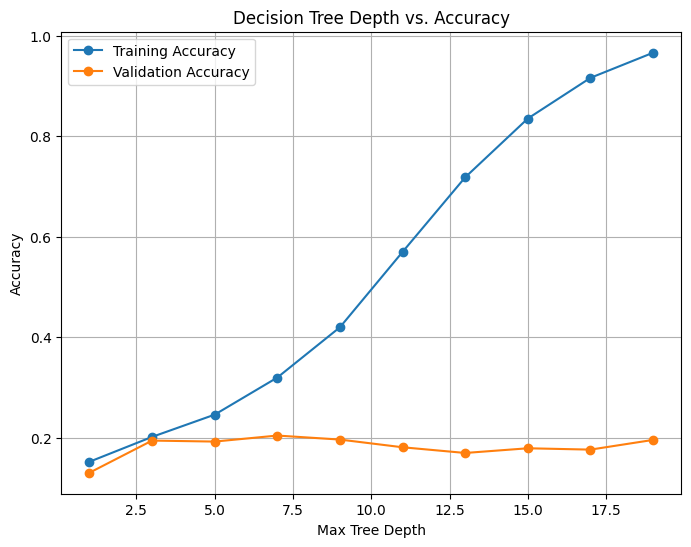

In [31]:
# 5. Depth vs. Accuracy plot (to tune the model)
# This shows how accuracy changes with tree depth
max_depths = [d for d in range(1, 21, 2)]
train_scores = []
val_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, dt_temp.predict(X_train)))
    val_scores.append(accuracy_score(y_val, dt_temp.predict(X_val)))

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training Accuracy')
plt.plot(max_depths, val_scores, 'o-', label='Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Runtime Performance Summary

In [32]:
# Runtime performance summary
runtime_summary = {
    'Total Images': len(y_train) + len(y_val),
    'Training Time (s)': train_time,
    'Inference Time (s)': inference_time,
    'Images per Second (Training)': len(y_train) / train_time,
    'Images per Second (Inference)': len(y_val) / inference_time
}

print("\nRuntime Performance Summary:")
for key, value in runtime_summary.items():
    print(f"{key}: {value}")


Runtime Performance Summary:
Total Images: 7500
Training Time (s): 64.95614552497864
Inference Time (s): 0.002231597900390625
Images per Second (Training): 92.37001289882146
Images per Second (Inference): 672164.1025641026


## Without PCA = The results
## With PCA results were not better:
## Train Accuracy: 0.39316666666666666
## Validation Accuracy: 0.19466666666666665

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Test 2 with PCA
# With PCA = True n_components=15
# Train Accuracy: 0.244
# Validation Accuracy: 0.202